In [1]:
import pickle
import spacy
import sys
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
sys.path.append('../../../')

In [3]:
from utils.wine_functions import custom_tokenizer

In [4]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "textcat", "ner"])

In [5]:
df = pd.read_csv('../../../data/df_red.csv', index_col = 0)

In [6]:
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery', 'type'],
      dtype='object')

In [7]:
df.shape

(71030, 14)

In [8]:
df

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,type
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,red
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,red
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,red
12,US,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini,red
16,Argentina,"Baked plum, molasses, balsamic vinegar and che...",Felix,87,30.0,Other,Cafayate,NaN,Michael Schachner,@wineschach,Felix Lavaque 2010 Felix Malbec (Cafayate),Malbec,Felix Lavaque,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129957,Spain,Lightly baked berry aromas vie for attention w...,Crianza,90,17.0,Northern Spain,Rioja,NaN,Michael Schachner,@wineschach,Viñedos Real Rubio 2010 Crianza (Rioja),Tempranillo Blend,Viñedos Real Rubio,red
129958,New Zealand,This blend of Cabernet Sauvignon-Merlot and Ca...,Irongate,90,35.0,Hawke's Bay,NaN,NaN,Joe Czerwinski,@JoeCz,Babich 2010 Irongate Red (Hawke's Bay),Bordeaux-style Red Blend,Babich,red
129960,Portugal,"Fresh and fruity, this is full of red cherry f...",Vértice,90,48.0,Douro,NaN,NaN,Roger Voss,@vossroger,Caves Transmontanas 2006 Vértice Pinot Noir (D...,Pinot Noir,Caves Transmontanas,red
129963,Israel,"A bouquet of black cherry, tart cranberry and ...",Oak Aged,90,20.0,Galilee,NaN,NaN,Mike DeSimone,@worldwineguys,Dalton 2012 Oak Aged Cabernet Sauvignon (Galilee),Cabernet Sauvignon,Dalton,red


In [9]:
#def custom_tokenizer(text):
 #   '''
  #  used to filter out unwanted words, punctuation, and so on
   # '''
    #tokens = []
    #for t in nlp(text):
     #   if not(len(t) < 2 or t.is_stop or t.like_num or 
      #         t.is_punct or not t.is_alpha):
       #     tokens.append(t.lemma_)
    #return tokens 

In [10]:
corpus = df['description']

In [11]:
corpus

1         This is ripe and fruity, a wine that is smooth...
4         Much like the regular bottling from 2012, this...
10        Soft, supple plum envelopes an oaky structure ...
12        Slightly reduced, this wine offers a chalky, t...
16        Baked plum, molasses, balsamic vinegar and che...
                                ...                        
129957    Lightly baked berry aromas vie for attention w...
129958    This blend of Cabernet Sauvignon-Merlot and Ca...
129960    Fresh and fruity, this is full of red cherry f...
129963    A bouquet of black cherry, tart cranberry and ...
129967    Citation is given as much as a decade of bottl...
Name: description, Length: 71030, dtype: object

In [12]:
y = df['variety']

In [13]:
y.value_counts()

Pinot Noir                       13272
Cabernet Sauvignon                9472
Red Blend                         8946
Bordeaux-style Red Blend          6915
Syrah                             4142
Merlot                            3102
Nebbiolo                          2804
Zinfandel                         2714
Sangiovese                        2707
Malbec                            2652
Portuguese Red                    2466
Tempranillo                       1810
Rhône-style Red Blend             1471
Cabernet Franc                    1353
Gamay                             1025
Shiraz                             836
Petite Sirah                       770
Sangiovese Grosso                  751
Barbera                            721
Port                               668
Grenache                           651
Corvina, Rondinella, Molinara      619
Tempranillo Blend                  588
Carmenère                          575
Name: variety, dtype: int64

In [14]:
bow = CountVectorizer(tokenizer=custom_tokenizer, 
                      ngram_range=(1, 1), 
                      min_df=0.01, 
                      max_df=0.99)

In [15]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, 
                                                              test_size=0.4, 
                                                              train_size=0.6)

In [16]:
X_train = bow.fit_transform(corpus_train)

In [17]:
X_train.shape

(42618, 398)

In [18]:
X_test = bow.transform(corpus_test)

In [19]:
m_nb = Pipeline([
    ('TfIdf', TfidfTransformer()),
    ('LR', LogisticRegression(class_weight='balanced'))
])

In [20]:
cross_val_score(m_nb, X_train, y_train, scoring='accuracy', n_jobs=4, cv=4).mean()

0.49711391645246494

In [21]:
m_nb.fit(X_train, y_train)

/home/samuelmcguire/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('TfIdf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('LR',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [22]:
pred = m_nb.predict(X_test)

In [23]:
metrics.f1_score(y_test, pred, average='weighted')

0.5351086975654499

In [24]:
metrics.accuracy_score(y_test, m_nb.predict(X_test))

0.5043291566943545

In [25]:
m_nb.predict(bow.transform(['cherry flavor nice oak accent']))

array(['Merlot'], dtype=object)

In [26]:
m_nb.predict_proba(bow.transform(['cherry flavor nice oak accent'])).max()

0.16486294058565315

In [28]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

confustion matrix
[[ 112    0    0 ...    0    0   15]
 [  15 1407   40 ...    1    1   19]
 [   1   10  214 ...    7   13    0]
 ...
 [   0    0    4 ...  188   10    0]
 [   1    1   20 ...   62  473    3]
 [  48    2    1 ...    5    1  548]]


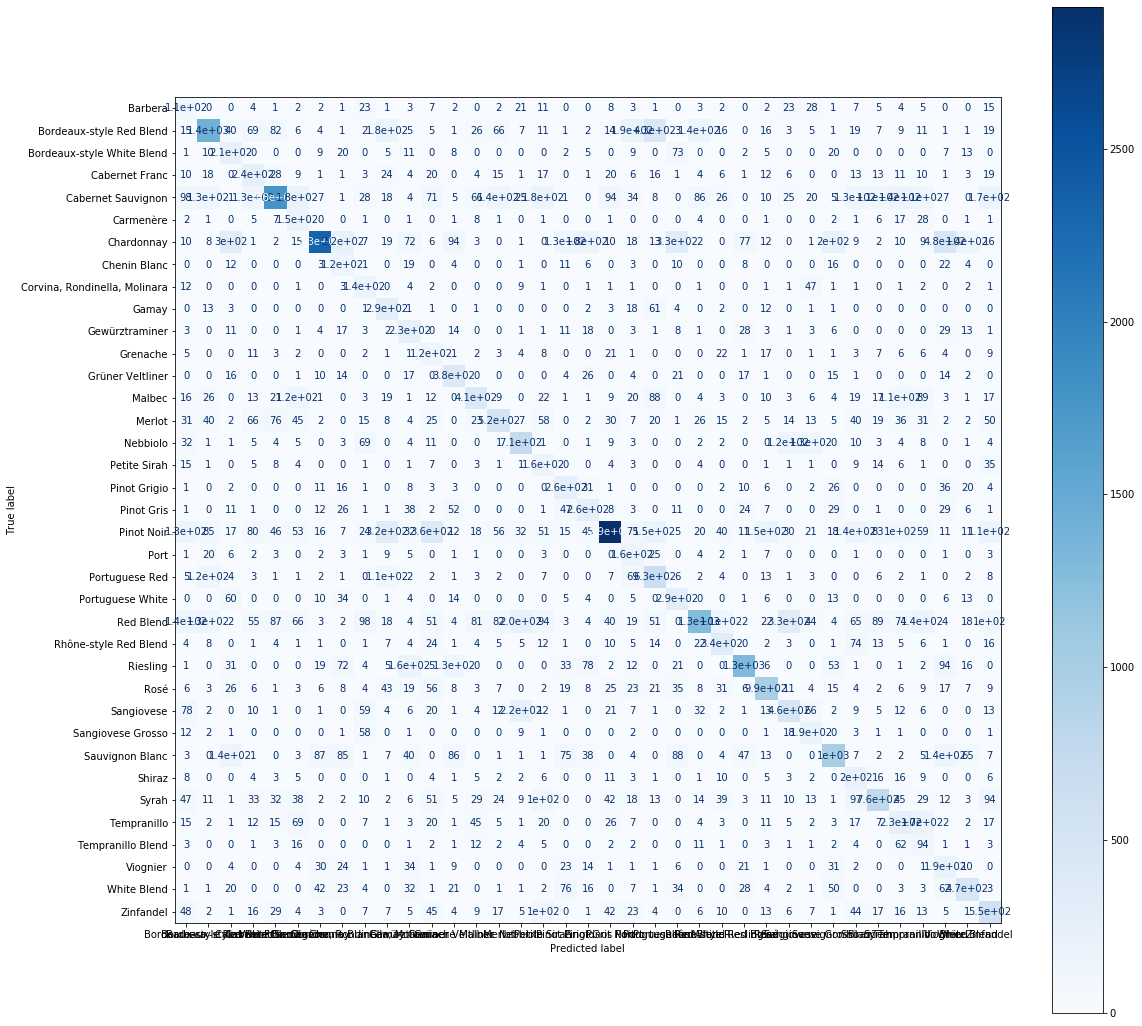

In [35]:
disp = plot_confusion_matrix(m_nb, X_test, y_test,
                            display_labels=m_nb.classes_,
                            cmap=plt.cm.Blues)

disp.ax_.set_title('confustion matrix')

disp.figure_.set_size_inches(18.5, 18.5)


print('confustion matrix')
print(disp.confusion_matrix)


plt.show()

In [27]:
with open('m_red.p', 'wb') as f:
    pickle.dump(m_nb, f)

In [28]:
with open('bow_red.p', 'wb') as f:
    pickle.dump(bow, f)